# Using Quality Flags to Create and Utilize Annotations

OOI utilizes the SAMI2-pH sensor from [Sunburst Sensors, LLC](http://www.sunburstsensors.com/) to measure seawater pH at multiple locations throughout the different arrays. Assessing the quality of the data from the instrument is an involved process as there are multiple parameters produced by the instrument that are then used to calculate the seawater pH. These different measurements are subject to different sources of error, and those errors can propogate through the calculations to create an erroneous seawater pH value. Based upon the vendor documentation and Matlab code they provide to convert the raw measurements, we can create [a set of rules](https://github.com/oceanobservatories/ooi-data-explorations/blob/master/python/ooi_data_explorations/uncabled/process_phsen.py#L152) from those different measurements to flag the pH data as either `pass`, `suspect` or `fail` (using the QARTOD flag values of 1, 3 and 4, respectively).

The resulting flags can be used to remove `fail` data from any analysis. They can also be used to help generate annotations that can be used during further Human in the Loop (HITL) QC checks of the data to help refine quality metrics for the data. The code below will show how the quality rules can be used to remove bad pH data from a time series, and how they can be used to then create annotations. The impact of using these flags is shown with a set of before and after plots of the seawater pH as a function of temperature.

In [ ]:
%matplotlib inline
from ooi_data_explorations.common import load_gc_thredds
from ooi_data_explorations.uncabled.process_phsen import phsen_datalogger

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt

## Oregon Inshore Midwater Platform

Data from a pH sensor on the Oregon Inshore Surface Mooring (CE01ISSM) midwater platform (aka the Near Surface Instrument Frame, NSIF), deployed at 7 m depth (site depth is 25 m) is used for this analysis. Initially we are going to look at the telemetered data from Deployment 2 (October 2014 through April 2015).

In [2]:
# setup the request parameters to download the data from the M2M system
site = 'CE01ISSM'           # OOI Net site designator
node = 'RID16'              # OOI Net node designator
sensor = '06-PHSEND000'     # OOI Net sensor designator
method = 'telemetered'      # OOI Data delivery method
stream = 'phsen_abcdef_dcl_instrument'   # OOI data set (stream) name 
tag = '.*deployment0002.*PHSEN.*\\.nc$'  # limit request to PHSEN NetCDF files from Deployment 2

# download the data from the OOI Gold Copy THREDDS server
data = load_gc_thredds(site, node, sensor, method, stream, tag)

# re-organize and rename the variables and add the quality checks
phsen = phsen_datalogger(data)
phsen['seawater_ph'] = phsen['seawater_ph'].where((phsen['seawater_ph'] > 6.9) & (phsen['seawater_ph'] < 9.0))

Merging the data files into a single dataset


Part of the `phsen_datalogger` module (imported above, and used to reorganize and restructure the data downloaded from OOI into a more useful form) is a function to assess the data quality. This function, called `quality_checks`, looks at select parameters (signal and reference channels) used to calculate the seawater pH and sets a QARTOD style quality flag for each data point. We can use the quality flags to quickly highlight data marked as `fail`, as in the plot below

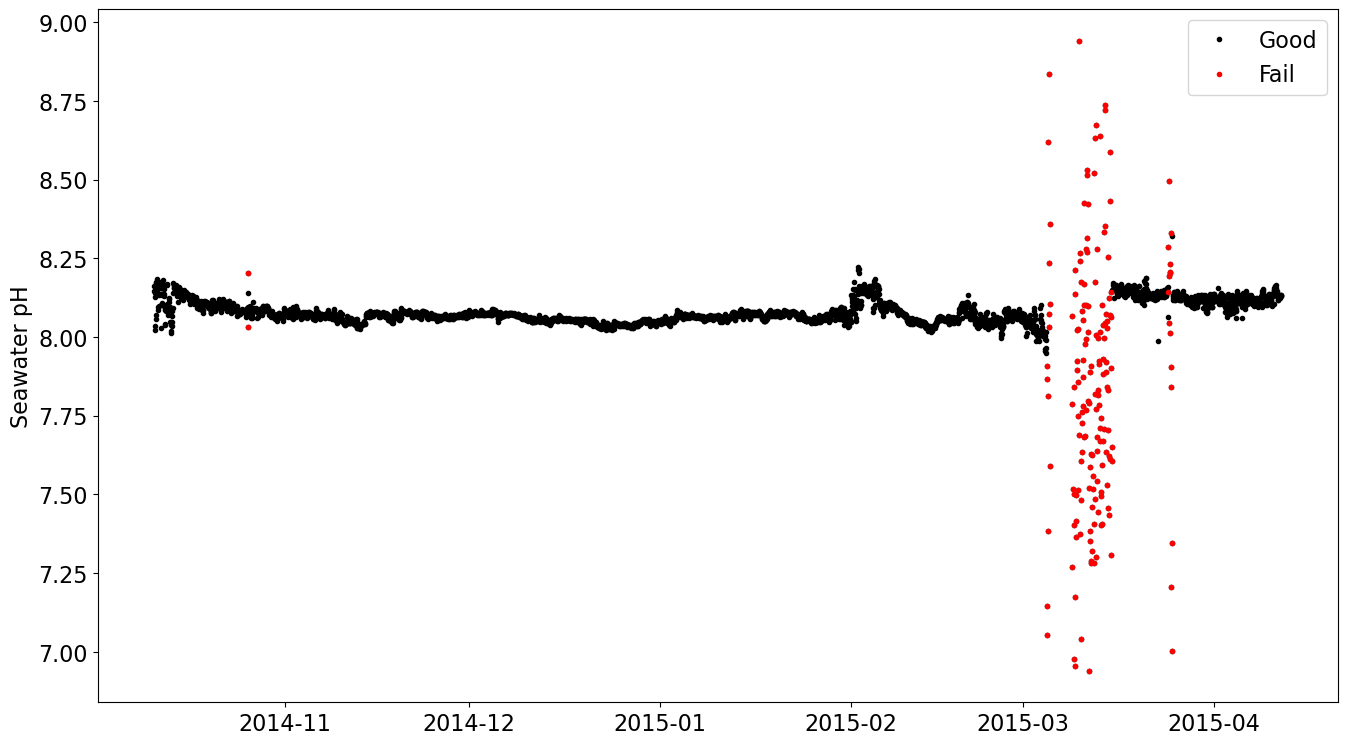

In [3]:
# plot the seawater pH values highlighting the "bad" data as defined by the quality checks
bad = phsen.where(phsen.seawater_ph_quality_flag==4)
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 16})
plt.plot(phsen['time'], phsen['seawater_ph'], '.k', label='Good')
plt.plot(bad['time'], bad['seawater_ph'], '.r', label='Fail')
plt.ylabel('Seawater pH')
plt.legend()